## Text Classification- Consumer Complaints

### Abstract

Text data is a common form of unstructured data and getting meaningful insights from text data can be difficult. Supervised machine learning algorithms can be used to classify text documents using Natural Language Processing techniques. Text classification involves trying to organize text documents into various categories based on inherent properties or attributes of the text document. Here we are trying to determine which product class the text documents belong.We will have trained text classification model at the end of the project.

### Problem Statement

A large amount of data is generated via the SDK Bank's consumer complaints tool. Each complaint has a narrative which can be used to categorize it’s relation to bank's product. Currently complaints are classified by support specialists. Classifying the complaints will  allow redirecting the complaints to the correct department as soon as complaints are logged. The classified complaints will be verified by the departments before processing. A text classifier can provide immediate cost savings, better SLA and more accurate predictions than a human counterpart. Improved customer satisfaction and improved efficiency of common workflows are major outcomes


### Objective

The objective of this project is to classify the consumer complaints by product category using Supervised Machine Learning techniques. Mortgage and Debt Collection are the two products classes selected for Text classification.


In [2]:
!python --version

Python 3.7.7


In [3]:
#all libraries
import pandas as pd
import re #text preprocessing and wrangling
import os
import spacy
import matplotlib.pyplot as plt
pd.options.display.max_colwidth =500
#os.getcwd()

### Read Data

In [4]:
raw=pd.read_csv("complaints-2021.csv",parse_dates=['Date received','Date sent to company'])

In [5]:
#rename columns
names=['recieved_date','product','subproduct','issue','subissue','consumer_complaint_narrative','company_response_public','company','state','zipcode','tags','consumer_consent_provided','submit_mode','senttocompany_date','company_response_consumer','timely_response','consumer_disputed','id']
raw.columns=names

### Dataset Description

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 0 to 5232
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   recieved_date                 5233 non-null   datetime64[ns]
 1   product                       5233 non-null   object        
 2   subproduct                    5233 non-null   object        
 3   issue                         5233 non-null   object        
 4   subissue                      5233 non-null   object        
 5   consumer_complaint_narrative  5233 non-null   object        
 6   company_response_public       5233 non-null   object        
 7   company                       5233 non-null   object        
 8   state                         5233 non-null   object        
 9   zipcode                       5233 non-null   object        
 10  tags                          5233 non-null   object        
 11  consumer_consent_provided     

### Exploratory Analysis

In [7]:
#count by product type
raw['product'].value_counts()

Debt collection    3356
Mortgage           1877
Name: product, dtype: int64

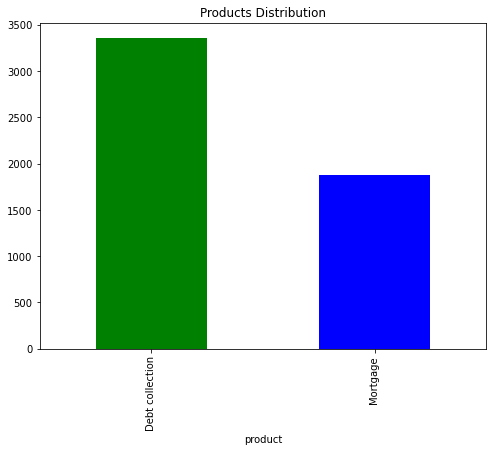

In [8]:
fig = plt.figure(figsize=(8,6))
raw.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0,color=['green','blue'])
plt.title('Products Distribution')
plt.show()

In [9]:
#count by state
raw["state"].value_counts()

CA                                      643
TX                                      576
FL                                      560
GA                                      372
NY                                      230
PA                                      210
NJ                                      179
IL                                      178
MD                                      151
AZ                                      140
MA                                      135
NC                                      132
VA                                      130
MI                                      123
OH                                      111
TN                                       98
MO                                       95
AL                                       92
WA                                       92
NV                                       83
SC                                       81
CO                                       75
WI                              

Text(0.5, 1.0, 'Top 10 states by complaints')

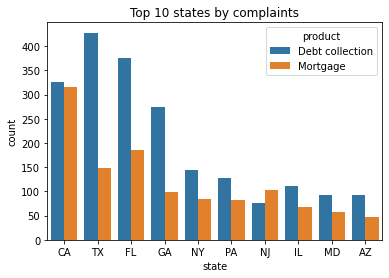

In [10]:
#State wise distribution

import seaborn as sns
sns.countplot(data=raw,x='state',hue='product',order=raw.state.value_counts().iloc[:10].index).set_title("Top 10 states by complaints")



Text(0.5, 1.0, 'Complaints by Date')

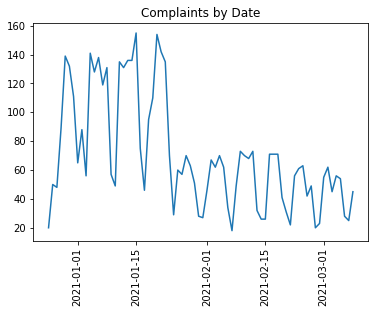

In [11]:
cnt =raw.groupby('recieved_date').size().rename('Count')
result = raw.drop_duplicates(subset='recieved_date')\
    .merge(cnt, left_on='recieved_date', right_index=True)
result = result.sort_values('recieved_date', ascending=True)
plt.plot(result['recieved_date'], result['Count'])
plt.xticks(rotation='vertical')
plt.title('Complaints by Date')

### Text Preprocessing

In [12]:
#dataframe for text classification

complaints=raw.loc[:,['product','consumer_complaint_narrative']]
complaints.head()

,product,consumer_complaint_narrative
0,Debt collection,"I received a letter dated XX/XX/XXXX, stating that my Federal loan debt ( approximately XXXX ) was taken over by another company after the initial company, Conserv/Ascendium in conjunction with XXXX XXXX XXXX XXXX, conducted a financial review/administrative hearing to determine if and what I could pay on the past loans. I never received any resolution from Conserv/ECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company, NES, or Nati..."
1,Debt collection,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment."
2,Debt collection,"I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info."
3,Debt collection,"Starting around XX/XX/XXXX, I receive a call every day around XXXX XXXX ( except maybe Sunday XXXX from phone number XXXX. I have not answered. Today, XX/XX/XXXX, I inadvertently called the number. I was trying to get the complete phone number so I could file this complaint. \n\nI heard a recorded voice that gave an amount owed, a notice of a convenience fee for collecting payment, and a website : sequium.com. There is no collection account information on my credit report, I've received noth..."
4,Mortgage,Background : New Res Shellpoint Mtg took over the mortgage servicing of our loan from XXXX XXXX XXXX when we file for Chapter XXXX Bankruptcy protection on XX/XX/XXXX. We were behind on payments and included them in our plan. \n\nWhen the loan was transferred from XXXX XXXX XXXX to Shellpoint on XX/XX/XXXX. Either XXXX XXXX XXXX or Shellpoint didn't record our payment of {$3500.00} which was paid on XX/XX/XXXX electronically posted according to XXXX XXXX. \n\nThis threw our payment history...


In [13]:
complaints.isnull().sum()

product                         0
consumer_complaint_narrative    0
dtype: int64

In [14]:
#clean function using regex

def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    s = re.sub(r"\With",'', s )
    s = re.sub(r"\d", "", s)
    s= re.sub(r"[-}):,@\?\$%_({+"".]", "", s)
    s=re.sub(r'[XX/XX/XXXX]*', '', s)
    s=re.sub(r"\n", "", s)
    #s=re.sub(r"\b[a-zA-Z]\b", "", s)
    s= re.sub(r"\s+"," ", s)
    #s=re.sub(r"^\s+", "", s)
    s=s.replace('""', "")
    #s=s.replace("'", "")
    s=s.replace('"', "")
    s=re.sub("\s\s+" , " ", s)
    return str(s)

In [15]:
#add new column to dataframe for clean narrative
complaints['narrative_clean']=''

In [16]:
#iterate through all the rows
for i, row in complaints.iterrows():
    complaints.at[i, 'narrative_clean'] = clean(row.consumer_complaint_narrative)

In [17]:
#check few rows
complaints.head(10)

,product,consumer_complaint_narrative,narrative_clean
0,Debt collection,"I received a letter dated XX/XX/XXXX, stating that my Federal loan debt ( approximately XXXX ) was taken over by another company after the initial company, Conserv/Ascendium in conjunction with XXXX XXXX XXXX XXXX, conducted a financial review/administrative hearing to determine if and what I could pay on the past loans. I never received any resolution from Conserv/ECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company, NES, or Nati...",I received a letter dated stating that my Federal loan debt approximately was taken over by another company after the initial company ConservAscendium in conjunction with conducted a financial reviewadministrative hearing to determine if and what I could pay on the past loans I never received any resolution from ConservECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company NES or National Enterprise System Again I did not receive a ...
1,Debt collection,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment.",Bonneville debt collection has called twice about a week ago and today leaving a message but no detail other than a callback number I don't have any unpaid debts and when trying to call the number they provide you just sit on hold in a queue for over an hour No one answers Considering this isn't my debt this is harassment
2,Debt collection,"I sent a certified verification of debt letter to the Medical Business Bureau. Unfortunately, the bureau failed to provide any documentation with my signature verifying this debt. I can not pay and will not pay anything that can not be verified. I requested detailed documentaion and the Bureau could not proivde this info.",I sent a certified verification of debt letter to the Medical Business Bureau Unfortunately the bureau failed to provide any documentation with my signature verifying this debt I can not pay and will not pay anything that can not be verified I requested detailed documentaion and the Bureau could not proivde this info
3,Debt collection,"Starting around XX/XX/XXXX, I receive a call every day around XXXX XXXX ( except maybe Sunday XXXX from phone number XXXX. I have not answered. Today, XX/XX/XXXX, I inadvertently called the number. I was trying to get the complete phone number so I could file this complaint. \n\nI heard a recorded voice that gave an amount owed, a notice of a convenience fee for collecting payment, and a website : sequium.com. There is no collection account information on my credit report, I've received noth...",Starting around I receive a call every day around except maybe Sunday from phone number I have not answered Today I inadvertently called the number I was trying to get the complete phone number so I could file this complaint I heard a recorded voice that gave an amount owed a notice of a convenience fee for collecting payment and a website sequiumcom There is no collection account information on my credit report I've received nothing in the mail and any collection debt in the past is paid an...
4,Mortgage,Background : New Res Shellpoint Mtg took over the mortgage servicing of our loan from XXXX XXXX XXXX when we file for Chapter XXXX Bankruptcy protection on XX/XX/XXXX. We were behind on payments and included them in our plan. \n\nWhen the loan was transferred from XXXX XXXX XXXX to Shellpoint on XX/XX/XXXX. Either XXXX XXXX XXXX or Shellpoint didn't record our payment of {$3500.00} which was paid on XX/XX/XXXX electronically posted according to XXXX XXXX. \n\nThis threw our payment history...,Background New Res Shellpoint Mtg took over t

In [18]:
#load spacy
nlp = spacy.load('en_core_web_sm')

#check pos and tags for sample text
test_sentence=complaints.iloc[0,2]
test_word=test_sentence.split()
spacy_pos_tagged = [(test_word, test_word.tag_, test_word.pos_) for test_word in nlp(test_sentence)]
pd.DataFrame(spacy_pos_tagged).T

,0,1,2,3,4,5,6,7,8,9,...,584,585,586,587,588,589,590,591,592,593
0,I,received,a,letter,dated,stating,that,my,Federal,loan,...,times,Thanks,for,your,help,in,the,matter,Kind,regards
1,PRP,VBD,DT,NN,VBN,VBG,IN,PRP$,NNP,NN,...,NNS,NNS,IN,PRP$,NN,IN,DT,NN,NNP,VBZ
2,PRON,VERB,DET,NOUN,VERB,VERB,SCONJ,PRON,PROPN,NOUN,...,NOUN,NOUN,ADP,PRON,NOUN,ADP,DET,NOUN,PROPN,VERB


### Natural Language Processing

In [19]:
#tags and pos
for i, row in complaints.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["narrative_clean"] and len(str(row["narrative_clean"])) < 1000000):
        doc = nlp(str(row["narrative_clean"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        complaints.at[i, "narrative_lemma"] = " ".join(lemmas)                
        complaints.at[i, "narrative_nouns"] = " ".join(nouns)
        complaints.at[i, "narrative_adjectives"] = " ".join(adjectives)
        complaints.at[i, "narrative_verbs"] = " ".join(verbs)
        complaints.at[i, "narrative_nav"] = " ".join(nouns+adjectives+verbs)
        complaints.at[i, "no_tokens"] = len(lemmas)

0
1000
2000
3000
4000
5000


In [20]:
#check few rows
complaints.head(10)

,product,consumer_complaint_narrative,narrative_clean,narrative_lemma,narrative_nouns,narrative_adjectives,narrative_verbs,narrative_nav,no_tokens
0,Debt collection,"I received a letter dated XX/XX/XXXX, stating that my Federal loan debt ( approximately XXXX ) was taken over by another company after the initial company, Conserv/Ascendium in conjunction with XXXX XXXX XXXX XXXX, conducted a financial review/administrative hearing to determine if and what I could pay on the past loans. I never received any resolution from Conserv/ECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company, NES, or Nati...",I received a letter dated stating that my Federal loan debt approximately was taken over by another company after the initial company ConservAscendium in conjunction with conducted a financial reviewadministrative hearing to determine if and what I could pay on the past loans I never received any resolution from ConservECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company NES or National Enterprise System Again I did not receive a ...,I receive a letter date state that my Federal loan debt approximately be take over by another company after the initial company ConservAscendium in conjunction with conduct a financial reviewadministrative hearing to determine if and what I could pay on the past loan I never receive any resolution from conservecmc but the next time I hear anything about my loan be when I be contact with a letter from the new company NES or National Enterprise System again I do not receive a determination let...,letter Federal loan debt company company ConservAscendium conjunction hearing loan resolution time loan letter company NES National Enterprise System determination letter conclusion review collector National Enterprise System NES phone call NES manager letter department Mr admission phone call option ability loan loan servicer option mr conversation lunch break morning Mr conversation option company letter day paperwork loan rehabilitation program number document tax return IRS documentation...,initial financial reviewadministrative past next new initial new first federal happy initial short following prior proper financial personal comfortable true financial important future much important outright upset unethical unprofessional few willing good good initial sound financial past rogue unethical unprofessional local current,receive date state take conduct determine pay receive hear be contact receive contact name contact ext route accord send have be rehabilitate be hear start have cut call ask call agree plan call go ask base send state send begin refuse demand give roundabout eg state feel do be be determine make lie state speak tell have base owe hear assume intimidate give want conclude rehabilitate be switch become accuse be rehabilitate mislead lie represent work lie get want threaten garnish give claim r...,letter Federal loan debt company company ConservAscendium conjunction hearing loan resolution time loan letter company NES National Enterprise System determination letter conclusion review collector National Enterprise System NES phone call NES manager letter department Mr admission phone call option ability loan loan servicer option mr conversation lunch break morning Mr conversation option company letter day paperwork loan rehabilitation program number document tax return IRS documentation...,594.0
1,Debt collection,"Bonneville debt collection has called twice ( about a week ago and today XX/XX/2021 ) leaving a message but no detail other than a callback number. I don't have any unpaid debts and when trying to call the number they provide, you just sit on hold in a queue for over an hour. No one answers. Considering this isn't my debt, this is harassment.",Bonneville debt collection has called twice about a week ago and today leaving a message but no detail other than a callback n

In [21]:
len(complaints)

5233

In [22]:
complaints.count()

product                         5233
consumer_complaint_narrative    5233
narrative_clean                 5233
narrative_lemma                 5233
narrative_nouns                 5233
narrative_adjectives            5233
narrative_verbs                 5233
narrative_nav                   5233
no_tokens                       5233
dtype: int64

In [23]:
#Tokenising function
#def my_tokenizer(text):
#  return text.split() if text != None else []

In [24]:
#tokens=complaints.narrative_clean.map(my_tokenizer).sum()

In [25]:
#from collections import Counter
#counter = Counter(tokens)
#counter.most_common(20)

### Tokenization and Stop word removal

In [26]:
#tokenizing clean text
complaints['narrative_tokens']=complaints['narrative_clean'].apply(lambda x: nlp.tokenizer(x))

In [27]:
#function to remove stop words
def remove_stops(tokens):
    return [token.text for token in tokens if not token.is_stop]

In [28]:
#add a new column with no stop words
complaints['narrative_nostopwords']=complaints['narrative_tokens'].apply(remove_stops)

In [29]:
#all tokens 
tokens_clean = complaints.narrative_nostopwords.sum()

In [30]:
#most common tokens
from collections import Counter

counter_token = Counter(tokens_clean)
counter_token.most_common(20)

[('credit', 5998),
 ('account', 5476),
 ('debt', 5285),
 ('loan', 3988),
 ('payment', 3946),
 ('company', 3630),
 ('information', 3404),
 ('received', 3225),
 ('mortgage', 3101),
 ('report', 2881),
 ('told', 2654),
 ('sent', 2547),
 ('time', 2292),
 ('called', 2288),
 ('letter', 2224),
 ('collection', 2185),
 ('paid', 2115),
 ('pay', 2067),
 ('payments', 1990),
 ('phone', 1683)]

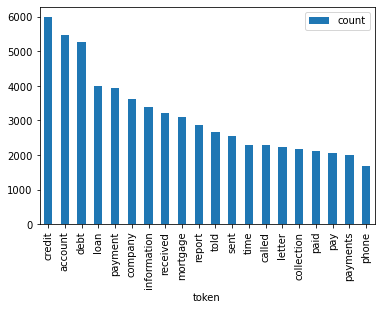

In [31]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter_token.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

In [32]:
#wordcloud
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter_token)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.title('Tokens worldcloud after stopwords removal')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

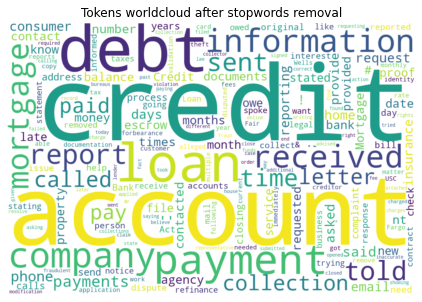

In [33]:
#wordcloud after tokenization and stopword removal
wordcloud(counter_token)

### Text Normalization

In [34]:
import nltk
from nltk.stem.porter import *

#### Stemming

In [35]:
stemmer = PorterStemmer()
#new column with stemmed text
complaints['narrative_stemmed']=complaints['narrative_nostopwords'].apply(lambda x: [stemmer.stem(y) for y in x])

In [36]:
#all stemmed tokens
tokens_stemmed = complaints.narrative_stemmed.sum()

In [37]:
#count stemmed tokens
counter_stemmed = Counter(tokens_stemmed)
counter_stemmed.most_common(20)

[('credit', 7406),
 ('account', 7007),
 ('report', 6356),
 ('payment', 6233),
 ('debt', 6008),
 ('loan', 5078),
 ('receiv', 4469),
 ('collect', 4442),
 ('inform', 4388),
 ('mortgag', 4331),
 ('compani', 4203),
 ('call', 3722),
 ('time', 3704),
 ('request', 3281),
 ('servic', 2736),
 ('pay', 2710),
 ('letter', 2707),
 ('state', 2680),
 ('told', 2677),
 ('sent', 2662)]

In [38]:
#define wordcloud for stemmed tokens
def wordcloud1(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.title('Tokens worldcloud after stemming')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

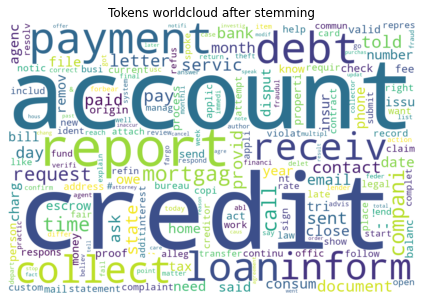

In [39]:
wordcloud1(counter_stemmed)

#### Lemmitization

In [40]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

#function to lemmitize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anupama\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
#new columns with lemmitized tokens
complaints['narrative_lemmatized']=complaints['narrative_nostopwords'].apply(lemmatize_text)

In [42]:
#all lemmatized tokens
tokens_lemmatized = complaints.narrative_lemmatized.sum()

In [43]:
#count all lemmatized tokens
counter_lemmatized = Counter(tokens_lemmatized)
counter_lemmatized.most_common(20)

[('account', 6209),
 ('credit', 6024),
 ('payment', 5936),
 ('debt', 5507),
 ('loan', 4219),
 ('company', 3948),
 ('report', 3490),
 ('time', 3485),
 ('information', 3404),
 ('received', 3225),
 ('mortgage', 3178),
 ('collection', 2691),
 ('told', 2654),
 ('letter', 2616),
 ('sent', 2547),
 ('called', 2288),
 ('day', 2172),
 ('paid', 2115),
 ('pay', 2088),
 ('month', 1997)]

In [44]:
#wordcloud for lemmatized tokens
def wordcloud2(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.title('Tokens worldcloud after lemmatization')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

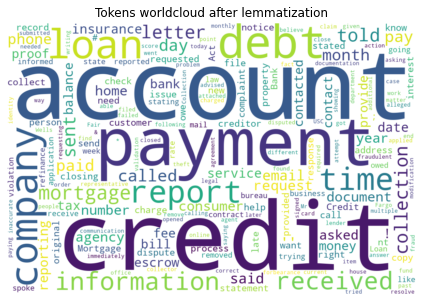

In [45]:
wordcloud2(counter_lemmatized)

In [56]:
complaints.head()


,product,consumer_complaint_narrative,narrative_clean,narrative_lemma,narrative_nouns,narrative_adjectives,narrative_verbs,narrative_nav,no_tokens,narrative_tokens,narrative_nostopwords,narrative_stemmed,narrative_lemmatized
0,Debt collection,"I received a letter dated XX/XX/XXXX, stating that my Federal loan debt ( approximately XXXX ) was taken over by another company after the initial company, Conserv/Ascendium in conjunction with XXXX XXXX XXXX XXXX, conducted a financial review/administrative hearing to determine if and what I could pay on the past loans. I never received any resolution from Conserv/ECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company, NES, or Nati...",I received a letter dated stating that my Federal loan debt approximately was taken over by another company after the initial company ConservAscendium in conjunction with conducted a financial reviewadministrative hearing to determine if and what I could pay on the past loans I never received any resolution from ConservECMC but the next time I heard anything about my loans was when I was contacted with a letter from the new company NES or National Enterprise System Again I did not receive a ...,I receive a letter date state that my Federal loan debt approximately be take over by another company after the initial company ConservAscendium in conjunction with conduct a financial reviewadministrative hearing to determine if and what I could pay on the past loan I never receive any resolution from conservecmc but the next time I hear anything about my loan be when I be contact with a letter from the new company NES or National Enterprise System again I do not receive a determination let...,letter Federal loan debt company company ConservAscendium conjunction hearing loan resolution time loan letter company NES National Enterprise System determination letter conclusion review collector National Enterprise System NES phone call NES manager letter department Mr admission phone call option ability loan loan servicer option mr conversation lunch break morning Mr conversation option company letter day paperwork loan rehabilitation program number document tax return IRS documentation...,initial financial reviewadministrative past next new initial new first federal happy initial short following prior proper financial personal comfortable true financial important future much important outright upset unethical unprofessional few willing good good initial sound financial past rogue unethical unprofessional local current,receive date state take conduct determine pay receive hear be contact receive contact name contact ext route accord send have be rehabilitate be hear start have cut call ask call agree plan call go ask base send state send begin refuse demand give roundabout eg state feel do be be determine make lie state speak tell have base owe hear assume intimidate give want conclude rehabilitate be switch become accuse be rehabilitate mislead lie represent work lie get want threaten garnish give claim r...,letter Federal loan debt company company ConservAscendium conjunction hearing loan resolution time loan letter company NES National Enterprise System determination letter conclusion review collector National Enterprise System NES phone call NES manager letter department Mr admission phone call option ability loan loan servicer option mr conversation lunch break morning Mr conversation option company letter day paperwork loan rehabilitation program number document tax return IRS documentation...,594.0,"(I, received, a, letter, dated, stating, that, my, Federal, loan, debt, approximately, was, taken, over, by, another, company, after, the, initial, company, ConservAscendium, in, conjunction, with, conducted, a, financial, reviewadministrative, hearing, to, determine, if, and, what, I, could, pay, on, the, past, loans, I, never, received, any, resolution, from, ConservECMC, but, the, next, time, I, heard, any

In [55]:
complaints['narrative_lemmatized']=complaints['narrative_lemmatized'].apply(lambda x: " ".join(x) )

In [65]:

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=2)
cv_matrix = cv.fit_transform(complaints['narrative_lemmatized'])
#cv.vocabulary_
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [66]:
# get all unique words in the corpus
vocab = cv.get_feature_names()


In [67]:
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,aargon,ab,abandonment,abd,abide,abiding,ability,able,abovelisted,abovementioned,...,york,young,yr,zero,zeroed,zip,zombie,zone,zoning,zuntafi
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
